In [1]:
from google.genai import types
from google.adk.agents import LlmAgent
from google.adk.models.google_llm import Gemini
from google.adk.runners import InMemoryRunner
from google.adk.sessions import InMemorySessionService
from google.adk.tools import google_search, AgentTool, ToolContext
from google.adk.code_executors import BuiltInCodeExecutor
from google.adk.sessions import DatabaseSessionService
from google.adk.sessions import InMemorySessionService
from google.adk.runners import Runner

In [2]:
import os
from getpass import getpass

if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"]=getpass("ApiKey:")


ApiKey: ········


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
#Tool for read the CSV and inspect for missing values
def analyze_missing_data(df_path:str)->dict:
    """
    Reads a CSV file into a pandas DataFrame, prints the total number of rows 
    and columns, and returns a detailed dictionary summary of missing (NaN) values 
    for every column that has them. Returns "No missing values found." if clean.
    """
    try:
        df=pd.read_csv(df_path)
        
        #Calculate missing data sum
        missing_data=df.isnull().sum()
        #We keep only the columns that have missing values
        missing_data=missing_data[missing_data>0]
        #Data type conversion
        missing_dict = {col: int(val) for col, val in missing_data.items()}
        
        if missing_data.empty:
            return {
                "status":"success",
                "message":"No missing values found.",
                "missing_data":{}
            }
        else:
            return {
                "status":"success",
                "message":"Missing values detected",
                "missing_data": missing_dict,
                "total_rows":len(df)
            }
    except Exception as e:
        return {
            "status":"error",
            "message":str(e)
        }

In [5]:
#Tool to fill missing values using the mean
def impute_data_with_mean(df_path:str,column_name:str)->dict:
    """
    Loads the CSV file, fills missing values (NaNs) in the specified column 
    with the mean of that column, and saves the modified DataFrame back 
    to the original path. Reports the result and the new missing count.
    
    Args:
        df_path: Path to the CSV file (e.g., 'data/train.csv').
        column_name: The column in which to fill NaNs.
        
    Returns:
        A dict confirming the imputation result.
    """
    try:
        df=pd.read_csv(df_path)
        
        if column_name not in df.columns:
            return {
                "status":"error",
                "message":f"Column '{column_name}' not found in dataset"
            }

        #Calculate mean and impute and Data type conversion
        impute_value=float(df[column_name].mean())
        initial_missing_count=int(df[column_name].isnull().sum())
        
        df[column_name]=df[column_name].fillna(impute_value)
    
        #Save back to the original path
        df.to_csv(df_path,index=False)
        
        return {
            "status":"success",
            "column":column_name,
            "imputed_value":impute_value,
            "filled_count":initial_missing_count,
            "message":f"Successfully filled {initial_missing} missing values with mean: {impute_value:.2f}"
        }
    
    except Exception as e:
        return {
            "status":"error",
            "message":str(e)
        }

In [6]:
import sys
from io import StringIO

# Custom tool to execute code and return a DICT
def execute_python_code(code: str) -> dict:
    """
    Executes Python code and returns the output (stdout) or error in a structured dictionary.
    Useful for calculating stats, filtering data, or creating plots.
    """
    # Capture standard output (print statements)
    old_stdout = sys.stdout
    redirected_output = StringIO()
    sys.stdout = redirected_output

    try:
        # Execute the code
        # Note: We use a shared dictionary for variables if you want state to persist, 
        # but for simple tasks 'locals()' or a new dict is safer.
        exec(code, globals())
        
        # Get the output
        sys.stdout = old_stdout
        output = redirected_output.getvalue()
        
        return {
            "status": "success",
            "code_executed": code,
            "output": output if output else "Code executed successfully (no output).",
            "message": "Code ran without errors."
        }

    except Exception as e:
        sys.stdout = old_stdout
        return {
            "status": "error",
            "error_type": type(e).__name__,
            "message": str(e)
        }


In [7]:
#Tool to fill missing values using the mode
def impute_data_with_mode(df_path:str,column_name:str)->dict:
    """
    Fills missing values in a categorical/object column with the most frequent value (mode)
    """
    try:
        df=pd.read_csv(df_path)

        if column_name not in df.columns:
            return {
                "status":"error",
                "message":f"Column '{column_name}' not found. "
            }

        if df[column_name].mode().empty:
            return {
                "status":"error",
                "message":f"Could not determine mode for {column_name} (column might be empty)"
            }
        
        impute_value=df[column_name].mode()[0]
        initial_missing = int(df[column_name].isnull().sum())

        #Check if missing values are more than 50% of the total rows
        if initial_missing>len(df['Age'])*0.5:
            return{
                "status":"skipped",
                "reason":"too many missing values",
                "message":f"Column '{column_name}' has too many missing values ({initial_missing}/{total_rows}). Imputing with mode is not recommended as it would skew the data."
            }
        
        df[column_name]=df[column_name].fillna(impute_value)
        df.to_csv(df_path,index=False)

        return{
            "status":"success",
            "column": column_name,
            "imputed_value":str(impute_value),
            "filled_counts":initial_missing,
            "message":f"Successfully filled {initial_missing} missing values in '{column_name}' with mode: '{impute_value}'"
        }
    except Exception as e:
        return {
            "status":"error",
            "message":str(e)
        }


In [83]:
#Tool for data visualization
def generate_visualization(code:str,filename:str="plot.png")->dict:
    """
    Executes Python code to generate a plot using matplotlib/seaborn and saves it.
    The code MUST save the plot to the specified 'filename' (e.g., plt.savefig(filename)).
    """
    
    # This prevents previous plots from overlapping with the new one
    plt.clf()

    try:
        
        # We check if 'df' is already loaded in the global environment.
        # If it is, we use it. If not (e.g., after a restart), we reload it from the CSV.
        if 'df' in globals():
            dataframe=globals()['df']
        else:
            dataframe=pd.read_csv('train.csv')

        # We create a dictionary of variables that the AI's code can access.
        # This passes our dataframe ('df') and libraries (plt, sns, pd) to the code.
        local_vars={'df':dataframe,"plt":plt,"sns":sns,"pd":pd}
        
        # We run the code string within the global scope but with our specific local_vars
        exec(code,globals(),local_vars)

        if os.path.exists(filename):
            return{
                "status":"success",
                "message":f"Visualization saved succcessfully as '{filename}'",
                "file_path":filename
            }
        else:
            return{
                "status":"error",
                "message":f"Code executed but file '{filename}' was not found.Did you use plt.savefig('{filename}')?"     
            }
    except Exception as e:
        return{
            "status":"error",
            "message":str(e)
        }

In [36]:
retry_config = types.HttpRetryOptions(
    attempts=5,  # Maximum retry attempts
    exp_base=7,  # Delay multiplier
    initial_delay=1,
    http_status_codes=[429, 500, 503, 504],  # Retry on these HTTP errors
)

In [71]:
cleaner_agent = LlmAgent(
    name="cleaner_agent",
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    instruction="""You are an expert Data Analyst assistant.
    
    Your workflow for handling missing data:
    1. Use 'analyze_missing_data' to inspect the CSV file first.
    2. Check the "status" and "missing_data" in the response.
    3. For each column with missing values, decide the best strategy:
       - If the column is **NUMERIC** (e.g., Age, Fare), use 'impute_data_with_mean'.
       - If the column is **OBJECT/TEXT** (e.g., Cabin, Embarked), use 'impute_data_with_mode',if missing values are less than 50% of the total rows.
       - If missing values are more than 50% of the total rows ask the user for drop the column,and if user says yes then drop.
    4. If you need to perform other calculations, use 'execute_python_code'.
    5. Always verify your actions and summarize what you did (e.g., "Filled column X with mean value Y").
    CRITICAL: You MUST return a final summary string explaining what you did (e.g. "I cleaned column X"). Do not return empty.
    """,
    tools=[analyze_missing_data,impute_data_with_mean,impute_data_with_mode,execute_python_code],
)

In [72]:
visualizer_agent=LlmAgent(
    name="visualizer_agent",
    model=Gemini(model="gemini-2.5-flash-lite",retry_options=retry_config),
    instruction="""You are the Data Visualization Specialist.
    
    Your Goal: Create charts and plots to visualize data.
    Tools:
    1. `execute_python_code`: Use to calculate stats or prepare data.
    2. `generate_visualization`: Use to DRAW charts.
    
    Rules:
    - When writing code for `generate_visualization`, ALWAYS use `plt.savefig('filename.png')`.
    - Use 'seaborn' for better visuals.
    CRITICAL: You MUST return a final string confirming the plot was saved (e.g. "Plot saved as X.png"). Do not return empty.
    """,
    tools=[execute_python_code,generate_visualization]
)

In [73]:
root_coordinator=LlmAgent(
    name="analytics_coordinator",
    model=Gemini(model="gemini-2.5-flash-lite",retry_options=retry_config),
    instruction="""You are the Head of Data Analytics. Your goal is to fulfill the user's request by delegating tasks to your specialized team.

    YOUR TEAM (TOOLS):
    1. `cleaner_agent`: Call this expert to inspect data, find missing values, and fix them.
    2. `visualizer_agent`: Call this expert to generate charts, plots, and visualizations.

    WORKFLOW RULES:
    - If the user asks to analyze or clean data, delegate to `cleaner_agent`.
    - If the user asks for a chart/graph, delegate to `visualizer_agent`.
    - If the user asks for BOTH (e.g., "clean the data and then plot it"), call `cleaner_agent` FIRST, wait for the result, and THEN call `visualizer_agent`.
    - Always synthesize the final answer based on the reports from your team.
    """,
    tools=[AgentTool(cleaner_agent),AgentTool(visualizer_agent)]
)

In [74]:
session_service=InMemorySessionService()

runner=Runner(
    agent=root_coordinator,
    session_service=session_service,
    app_name="default"
)

### Test the Agent

In [75]:
session_id = "test_session_001"

In [76]:
df=pd.read_csv('train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [77]:
_=await runner.run_debug(
    "Bro I am working on 'train.csv' dataset. Check if dataset have missing values",
    session_id=session_id
)


 ### Created new session: test_session_001

User > Bro I am working on 'train.csv' dataset. Check if dataset have missing values


analytics_coordinator > I've inspected the 'train.csv' dataset and found missing values in the 'Age' (177 missing), 'Cabin' (687 missing), and 'Embarked' (2 missing) columns.

I recommend the following approach:
- Impute missing 'Age' values with the mean of the 'Age' column.
- Impute missing 'Embarked' values with the mode of the 'Embarked' column.
- Drop the 'Cabin' column as it has a high percentage of missing values.

Do you approve of this plan?


In [78]:
_=await runner.run_debug(
    "Yes do it",
    session_id=session_id
)


 ### Continue session: test_session_001

User > Yes do it


analytics_coordinator > I have successfully imputed the missing values in the 'Age' and 'Embarked' columns and removed the 'Cabin' column from the 'train.csv' dataset. The data is now clean.


In [79]:
_=await runner.run_debug(
    "Check for missing values",
    session_id=session_id
)


 ### Continue session: test_session_001

User > Check for missing values


analytics_coordinator > I have checked the 'train.csv' dataset, and there are no missing values.



 ### Continue session: test_session_001

User > Create a complex visualization: A Seaborn heatmap showing the correlation matrix of all numeric columns in 'train.csv'.Save it as 'correlation_heatmap.png'.


analytics_coordinator > I have generated a Seaborn heatmap that displays the correlation matrix of all numeric columns in 'train.csv'. The image has been saved as 'correlation_heatmap.png'.


<Figure size 640x480 with 0 Axes>

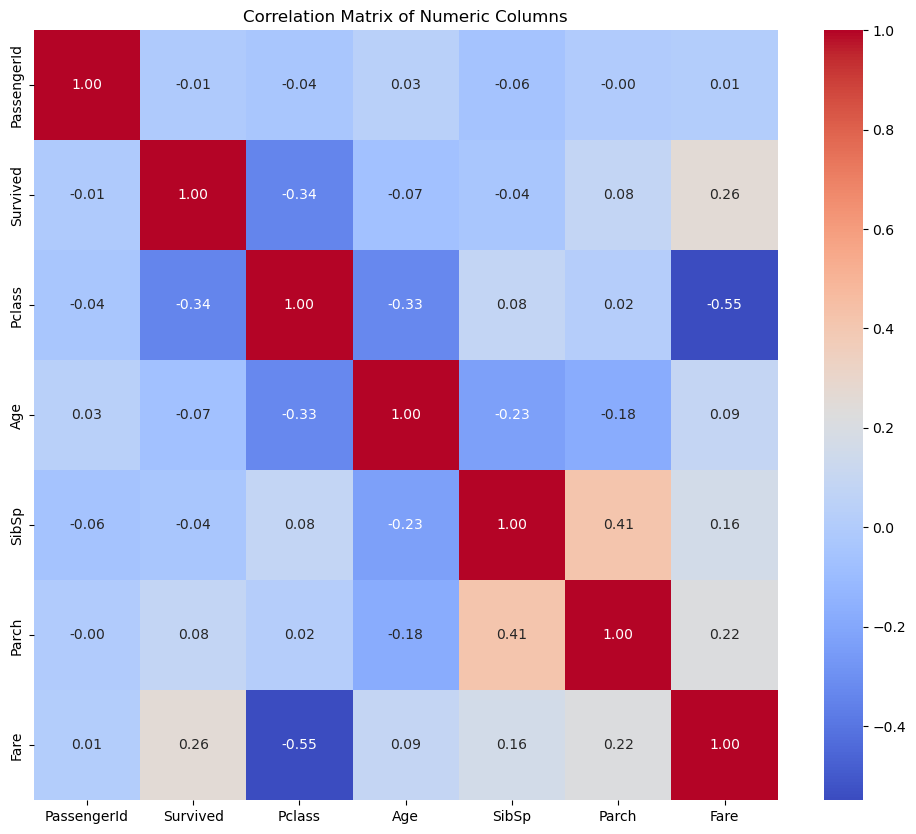

In [80]:
_=await runner.run_debug(
    "Create a complex visualization: A Seaborn heatmap showing the correlation matrix of all numeric columns in 'train.csv'.Save it as 'correlation_heatmap.png'.",
    session_id=session_id
)

In [81]:
df=pd.read_csv('train.csv')

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 76.7+ KB
